<a href="https://colab.research.google.com/github/sahilaf/Multimodel_rag_using_gemini/blob/main/Multi_model_rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install dependecies

In [1]:
!pip install --upgrade langchain langchain-google-genai "langchain[docarray]" faiss-cpu pypdf

In [2]:
!pip install -U langchain-community

## Imports

In [3]:
import os
import requests
from PIL import Image

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import display, Markdown

In [5]:
from langchain_google_genai import ChatGoogleGenerativeAI

In [6]:
from langchain_core.messages import HumanMessage, SystemMessage

In [7]:
from langchain_core.output_parsers import StrOutputParser

In [8]:
from langchain.vectorstores import DocArrayInMemorySearch
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_core.prompts import ChatPromptTemplate

In [9]:
import base64

In [10]:
from langchain.schema.document import Document
from langchain_community.document_loaders import TextLoader
from langchain.text_splitter import CharacterTextSplitter

In [11]:
from langchain_community.vectorstores import FAISS

## Loading Api key

In [12]:
from google.colab import userdata
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

## Loading Model

In [13]:
def load_model(model_name):
  if model_name=="gemini-flash":
    llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp")
  else:
    llm=ChatGoogleGenerativeAI(model="gemini-2.5-pro-exp-03-25")
  return llm

In [14]:
model_text=load_model("gemini-flash")

## Testing Gemini Api

In [15]:
model_text.invoke("Come up with the best funny line you know").content

'Okay, here\'s one that always gets a chuckle:\n\n**"I tried to explain to my kids that eggs come from chickens. They still think it\'s a grocery store thing."**\n\nWhy it works:\n\n*   **Relatability:** Many people can relate to kids misunderstanding basic facts.\n*   **Subversion of Expectations:** It highlights the disconnect between the natural world and a child\'s understanding.\n*   **Understatement:** The "grocery store thing" is a simple, funny way to describe their misconception.\n*   **It\'s clean:** Suitable for any audience.\n\nHopefully, that gives you a laugh!'

In [16]:
model_text.invoke(
    [
        HumanMessage(
            content="Come up with the best funny line you know"
        )
    ]
).content

'Okay, here\'s one that always gets a chuckle:\n\n**"I told my wife she was drawing her eyebrows too high. She seemed surprised."**\n\nWhy it works:\n\n*   **Wordplay:** It relies on the double meaning of "surprised."\n*   **Relatability:** Many people have experienced some form of eyebrow-related humor.\n*   **Simple and Quick:** It\'s easy to understand and doesn\'t require a long setup.\n\nHope you enjoyed it! Let me know if you want another one. 😜'

## Getting image from url

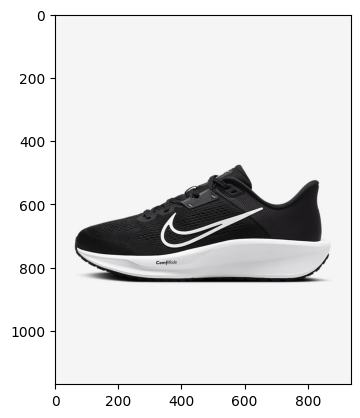

In [17]:
def get_image(url,filename,extension):
  content = requests.get(url).content
  with open(f'/content/{filename},{extension}','wb') as f:
    f.write(content)
  image = Image.open(f"/content/{filename},{extension}")
  image.show()
  return image

image =get_image("https://static.nike.com/a/images/t_PDP_936_v1/f_auto,q_auto:eco/378820bf-d936-411c-950b-b80e1033c454/NIKE+QUEST+6.png",
                 "NIKE+QUEST+6","png")

plt.imshow(mpimg.imread(f"/content/NIKE+QUEST+6,png"))
plt.show()

## Import bytesIO for embedding

In [18]:
from io import BytesIO

### Load Gemini Flash model

In [19]:
vision_model = load_model("gemini-flash")

## Convert image to base64 and test

In [20]:
def encode_image(image):
    buffered = BytesIO()
    image.save(buffered, format="PNG")  # Use "JPEG" if needed
    return base64.b64encode(buffered.getvalue()).decode()

encoded_image = encode_image(image)

# Prepare message correctly (Gemini Flash expects an actual URL or base64 data)
message = HumanMessage(
    content=[
        {
            "type": "image_url",
            "image_url": f"data:image/png;base64,{encoded_image}"  # Correct format
        }
    ]
)

# Invoke the model
response = vision_model.invoke([message])
print(response.content)

Here are the bounding box detections:
```json
[
  {"box_2d": [407, 66, 720, 931], "label": "shoe"}
]
```


In [21]:
message = HumanMessage(
    content=[
        {
            "type": "text",
            "text": "give me a summary of the image"
        },
        {
            "type": "image_url",
            "image_url": f"data:image/png;base64,{encoded_image}"
        }
    ]
)

# Invoke the vision model
response = vision_model.invoke([message]).content

# Print the response
print(response)


The image shows a side view of a black and white Nike running shoe against a white background. The upper part of the shoe is black, constructed from a mesh-like material. A large white Nike swoosh logo is prominently displayed on the side. The midsole is thick and white, with "ComfiRide" printed on it in black. The outsole is black, and the shoe has black laces.


## Loading Context in txt format

In [22]:
loader = TextLoader("/content/Nike.txt")
print(loader.load()[0].page_content)


Nike Air Max Plus sneakers. They feature a brown upper with a black Nike Swoosh logo on the side and a visible Air Max unit in the heel. The sole is white.
Here are some more details about the Nike Air Max Plus:
Style: TN
Release date: January 1, 2017
Style code: 852630-300
Original retail price: $150 USD
The Air Max Plus, also known as the TN, is a popular Nike running shoe that was first released in 1998. It is known for its unique design, which includes a gradient upper, visible Air Max units, and a wavy outsole. The TN has been a popular shoe among sneakerheads and casual wearers alike for over two decades.
It features a brown upper with a black Swoosh logo and a white sole. The shoe is currently available for resale on the StockX marketplace for an average price of around $150 USD.
Nike Air Max Plus Store Location: "Kings Way, Kathmandu, Nepal".
\n\n\n



Nike Dunk Low Retro sneakers.
Here are some more details about the Nike Dunk Low Retro:
Style: Low-top
Release date: October 3

In [23]:
text=loader.load()[0].page_content

## Converting the context in chunks and embed









In [24]:
def get_text_chunks_langchain(text):
  text_splitter = CharacterTextSplitter(chunk_size=20, chunk_overlap=10)
  docs = [Document(page_content=x) for x in text_splitter.split_text(text)]
  return docs

In [25]:
docs = get_text_chunks_langchain(text)

In [26]:
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

In [27]:
vectorstore = FAISS.from_documents(docs,embedding=embeddings)

In [28]:
retriever=vectorstore.as_retriever()

In [29]:
retriever.invoke("Nike slide/sandal.")

[Document(id='e73c4a58-3783-43c2-993e-2e232d044a39', metadata={}, page_content='Nike slide/sandal.\nThey appear to be the Nike Slide/Sandal, which is a unisex slide/sandal.\nHere are some of the features:\nSoft, one-piece upper: The upper is made of a soft, synthetic material that provides comfort and support.\nPhylon midsole: The midsole is made of Phylon, which provides cushioning and support.\nRubber outsole: The outsole is made of rubber for traction and durability.\nSwoosh logo: The Nike Swoosh logo is on the strap of the sandal.\nAvailable in a variety of colors: The Nike Benassi Solarsoft Sandal is available in a variety of colors, including black, white, and beige.\nNike off courte slides store location: "Bhaktapur, Nepal".'),
 Document(id='5669df43-51d1-439c-af41-2895459754fd', metadata={}, page_content='Nike Air Max Plus sneakers. They feature a brown upper with a black Nike Swoosh logo on the side and a visible Air Max unit in the heel. The sole is white.\nHere are some more

In [30]:
from langchain_core.runnables import RunnableLambda, RunnablePassthrough

In [31]:
llm_vision = load_model("gemini")

In [32]:
llm_text = load_model("gemini")

In [33]:
template = """
```
{context}
```

{query}


Provide brief information and store location.
"""

In [34]:
prompt = ChatPromptTemplate.from_template(template)

In [35]:
rag_chain = (
    {"context": retriever, "query": RunnablePassthrough()}
    | prompt
    | llm_text
    | StrOutputParser()
)

In [36]:
result = rag_chain.invoke("can you give me a detail of nike sandal?")

In [37]:
display(Markdown(result))

Based on the documents provided:

**Nike Slide/Sandal**

*   **Brief Information:** This appears to be a unisex slide/sandal. Key features include a soft, one-piece synthetic upper for comfort, a Phylon midsole for cushioning and support, and a rubber outsole for traction. It features the Nike Swoosh logo on the strap and is available in various colors like black, white, and beige.
*   **Store Location:** Bhaktapur, Nepal (associated with "Nike off courte slides").

In [38]:
rag_chain

{
  context: VectorStoreRetriever(tags=['FAISS', 'GoogleGenerativeAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x7b08b5ae3b50>, search_kwargs={}),
  query: RunnablePassthrough()
}
| ChatPromptTemplate(input_variables=['context', 'query'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'query'], input_types={}, partial_variables={}, template='\n```\n{context}\n```\n\n{query}\n\n\nProvide brief information and store location.\n'), additional_kwargs={})])
| ChatGoogleGenerativeAI(model='models/gemini-2.5-pro-exp-03-25', google_api_key=SecretStr('**********'), client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x7b08b5320350>, default_metadata=())
| StrOutputParser()

In [39]:
full_chain = (
    RunnablePassthrough() | llm_vision | StrOutputParser() | rag_chain
)

In [40]:
full_chain

RunnablePassthrough()
| ChatGoogleGenerativeAI(model='models/gemini-2.5-pro-exp-03-25', google_api_key=SecretStr('**********'), client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x7b08b5ada390>, default_metadata=())
| StrOutputParser()
| {
    context: VectorStoreRetriever(tags=['FAISS', 'GoogleGenerativeAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x7b08b5ae3b50>, search_kwargs={}),
    query: RunnablePassthrough()
  }
| ChatPromptTemplate(input_variables=['context', 'query'], input_types={}, partial_variables={}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'query'], input_types={}, partial_variables={}, template='\n```\n{context}\n```\n\n{query}\n\n\nProvide brief information and store location.\n'), additional_kwargs={})])
| ChatGoogleGenerativeAI(model='models/gemini-2.5-pro-exp-03-25', google_api_key=SecretStr('**********'), client=<googl

In [41]:
url_1 = "https://static.nike.com/a/images/t_PDP_1728_v1/f_auto,q_auto:eco/252f2db6-d426-4931-80a0-8b7f8f875536/calm-slides-K7mr3W.png"

In [42]:
image = get_image(url_1, "nike3", "png")

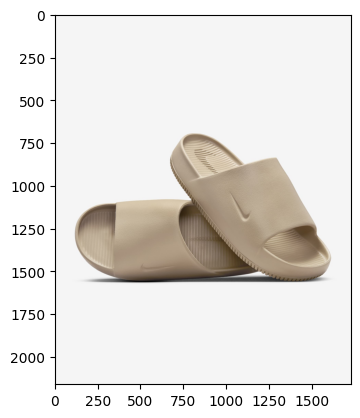

In [43]:
plt.imshow(image)
plt.show()

In [44]:
def encode_image(image):
    buffered = BytesIO()
    image.save(buffered, format="PNG")  # Use "JPEG" if needed
    return base64.b64encode(buffered.getvalue()).decode()

encoded_image = encode_image(image)

In [45]:
message = HumanMessage(
    content=[
        {
            "type": "text",
            "text": "Provide information on given sandle image Brand and model.",
        },
        {
            "type": "image_url",
            "image_url": f"data:image/png;base64,{encoded_image}"  # Correct format
        }
    ]
)


In [46]:
result = full_chain.invoke([message])

In [47]:
display(Markdown(result))

Based on the provided documents:

*   **Product:** Nike slide/sandal (specifically mentions "Nike Slide/Sandal" and "Nike Benassi Solarsoft Sandal" available in beige).
*   **Brief Information:** Features a soft, one-piece synthetic upper, Phylon midsole for cushioning, rubber outsole for traction, and the Swoosh logo on the strap. Available in various colors including beige.
*   **Store Location:** Bhaktapur, Nepal.